# Pré-processamento dos dados

## Declaração de bibliotecas e funções

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Mestrado/Reconhecimento de Padrões/Trabalho Final/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import scipy.io
from os import listdir
from os.path import isfile, join
from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from numpy import genfromtxt

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(10,10)):
  # Function by hitvoice
  # https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
  """
  Generate matrix plot of confusion matrix with pretty annotations.
  The plot image is saved to disk.
  args: 
  y_true:    true label of the data, with shape (nsamples,)
  y_pred:    prediction of the data, with shape (nsamples,)
  filename:  filename of figure file to save
  labels:    string array, name the order of class labels in the confusion matrix.
             use `clf.classes_` if using scikit-learn models.
             with shape (nclass,).
  ymap:      dict: any -> string, length == nclass.
             if not None, map the labels & ys to more understandable strings.
             Caution: original y_true, y_pred and labels must align.
  figsize:   the size of the figure plotted.
  """
  if ymap is not None:
    y_pred = [ymap[yi] for yi in y_pred]
    y_true = [ymap[yi] for yi in y_true]
    labels = [ymap[yi] for yi in labels]
  cm = confusion_matrix(y_true, y_pred, labels=labels)
  cm_sum = np.sum(cm, axis=1, keepdims=True)
  cm_perc = cm / cm_sum.astype(float) * 100
  annot = np.empty_like(cm).astype(str)
  nrows, ncols = cm.shape
  for i in range(nrows):
      for j in range(ncols):
          c = cm[i, j]
          p = cm_perc[i, j]
          if i == j:
              s = cm_sum[i]
              annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
          elif c == 0:
              annot[i, j] = ''
          else:
              annot[i, j] = '%.1f%%\n%d' % (p, c)
  cm = pd.DataFrame(cm, index=labels, columns=labels)
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  fig, ax = plt.subplots(figsize=figsize)
  sns.heatmap(cm, annot=annot, fmt='', ax=ax)
  plt.savefig(filename)

In [0]:
X = genfromtxt(r'gdrive/My Drive/Mestrado/Reconhecimento de Padrões/Trabalho Final/features.csv', delimiter=',')
y = genfromtxt(r'gdrive/My Drive/Mestrado/Reconhecimento de Padrões/Trabalho Final/target.csv', delimiter=',', dtype='<U3')

In [0]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

# Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1105)

In [42]:
kf = StratifiedKFold(n_splits=10, shuffle=True)
scores = []
final_scores = []

for train, test in kf.split(X_train, y_train):
  for i in range(10):
    rf = RandomForestClassifier(n_estimators = 50, max_depth = 20, min_samples_split = 2,
                                min_samples_leaf = 5, bootstrap = False, criterion = 'entropy')
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    scores.append(accuracy_score(y_pred, y_val))
  final_scores.append(sum(scores)/len(scores))

final_scores = np.array(final_scores)
print(f'Acurácia média para cada fold repetido 10 vezes\n: {np.round(final_scores * 100, decimals=2)}')
print(f'\nMédia da acurácia: {np.mean(final_scores) * 100:.2f}%')
print(f'Desvio padrão da acurácia: {np.std(final_scores) * 100:.2f}%)')

Acurácia média para cada fold repetido 10 vezes
: [88.94 88.72 88.83 88.96 88.89 88.92 88.94 88.88 88.85 88.86]

Média da acurácia: 88.88%
Desvio padrão da acurácia: 0.07%)


In [0]:
rf = RandomForestClassifier(n_estimators = 50, max_depth = 20, min_samples_split = 2,
                            min_samples_leaf = 5, bootstrap = False, criterion = 'entropy')
rf.fit(X_train, y_train.ravel())
y_pred = rf.predict(X_test)

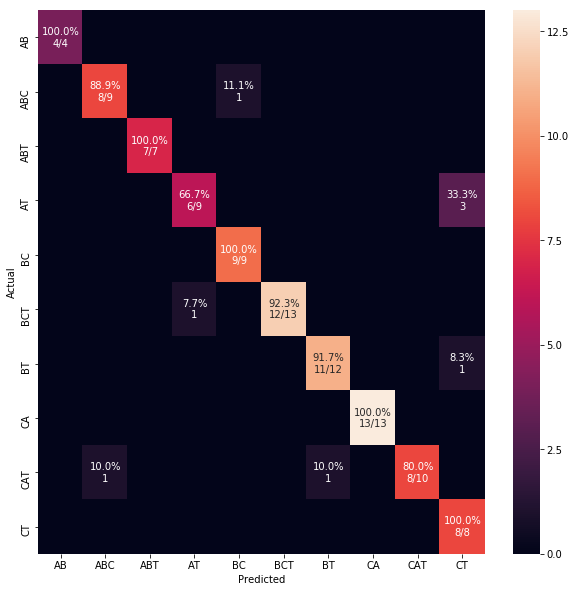

In [76]:
cm_analysis(y_test, y_pred, 'cm_rf.eps', rf.classes_, figsize=(10,10))

# Rede MLP

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import initializers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adagrad
from keras.utils import to_categorical

In [0]:
label_encoder = LabelEncoder()
label_encoder.fit(y.ravel())
y_train_integer = label_encoder.fit_transform(y_train.ravel())
y_test_integer = label_encoder.fit_transform(y_test.ravel())
y_val_integer = label_encoder.fit_transform(y_val.ravel())

In [0]:
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
y_train_onehot = onehot_encoder.fit_transform(y_train_integer.reshape(len(y_train_integer), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test_integer.reshape(len(y_test_integer), 1))
y_val_onehot = onehot_encoder.fit_transform(y_val_integer.reshape(len(y_val_integer), 1))

In [31]:
y_train_onehot.shape

(751, 10)

In [45]:
init = initializers.glorot_normal()
model = Sequential()
model.add(Dense(384, activation = 'relu', input_dim = X_train.shape[1],
                kernel_initializer = init, bias_initializer = init))
model.add(Dropout(0.2))
model.add(Dense(10, activation = 'softmax', 
                kernel_initializer = init, bias_initializer = init))
opt = Adagrad(lr=0.01, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])
stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose=1, patience=50)
history = model.fit(X_train, y_train_onehot, validation_data = (X_val, y_val_onehot), shuffle=True, batch_size = 50, 
          epochs = 5000, verbose = 1, callbacks=[stop])

Train on 751 samples, validate on 94 samples
Epoch 1/5000
751/751 [==============================] - 28s 37ms/step - loss: 2.0109 - acc: 0.3409 - val_loss: 1.9179 - val_acc: 0.2872
Epoch 2/5000
751/751 [==============================] - 0s 132us/step - loss: 1.4778 - acc: 0.5300 - val_loss: 1.8363 - val_acc: 0.2872
Epoch 3/5000
751/751 [==============================] - 0s 124us/step - loss: 1.2997 - acc: 0.5859 - val_loss: 1.4719 - val_acc: 0.5745
Epoch 4/5000
751/751 [==============================] - 0s 123us/step - loss: 1.1598 - acc: 0.6551 - val_loss: 1.5593 - val_acc: 0.4043
Epoch 5/5000
751/751 [==============================] - 0s 127us/step - loss: 1.1084 - acc: 0.6498 - val_loss: 1.4032 - val_acc: 0.4574
Epoch 6/5000
751/751 [==============================] - 0s 129us/step - loss: 1.0312 - acc: 0.7111 - val_loss: 1.3651 - val_acc: 0.5213
Epoch 7/5000
751/751 [==============================] - 0s 128us/step - loss: 0.9740 - acc: 0.7124 - val_loss: 1.2838 - val_acc: 0.6383
Epo

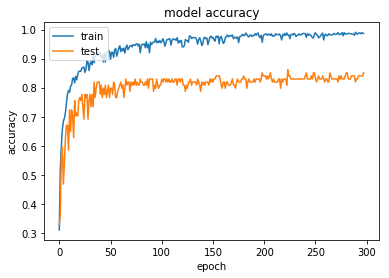

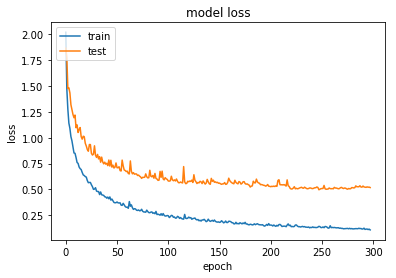

In [34]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('modelaccuracy.eps')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('modelloss.eps')
plt.show()

In [35]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=None)
cvscores = []
final_scores_mlp = []
for train, test in kfold.split(X_train, y_train_integer):
  for i in range(10):
    init = initializers.glorot_normal(seed=None)
    model = Sequential()
    model.add(Dense(384, activation='relu', input_dim = X_train.shape[1],
                    kernel_initializer = init, bias_initializer = init))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation = 'softmax', 
                    kernel_initializer = init, bias_initializer = init))
    opt = Adagrad(lr=0.01, epsilon=None, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])
    stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose=1, patience=50)
    filepath = r'gdrive/My Drive/Mestrado/Reconhecimento de Padrões/Trabalho Final/best_model_23_06.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    history = model.fit(X_train, y_train_onehot, validation_split = 0.1, shuffle=True, batch_size = 50, 
                        epochs = 5000, verbose = 0, callbacks=[stop, checkpoint])
    scores = model.evaluate(X_test, y_test_onehot, verbose=0)
    cvscores.append(scores[1] * 100)
  final_scores_mlp.append(sum(cvscores)/len(cvscores))
  
final_scores_mlp = np.array(final_scores_mlp)
print(f'Acurácia média para cada fold repetido 10 vezes: {np.round(final_scores_mlp, decimals=2)}')
print(f'\nMédia da acurácia: {np.mean(final_scores_mlp):.2f}%')
print(f'Desvio padrão da acurácia: {np.std(final_scores_mlp):.2f}%)')

Epoch 00189: early stopping
Epoch 00270: early stopping
Epoch 00225: early stopping
Epoch 00293: early stopping
Epoch 00244: early stopping
Epoch 00343: early stopping
Epoch 00288: early stopping
Epoch 00245: early stopping
Epoch 00323: early stopping
Epoch 00245: early stopping
Epoch 00184: early stopping
Epoch 00328: early stopping
Epoch 00406: early stopping
Epoch 00346: early stopping
Epoch 00376: early stopping
Epoch 00286: early stopping
Epoch 00266: early stopping
Epoch 00253: early stopping
Epoch 00321: early stopping
Epoch 00302: early stopping
Epoch 00161: early stopping
Epoch 00430: early stopping
Epoch 00329: early stopping
Epoch 00293: early stopping
Epoch 00252: early stopping
Epoch 00277: early stopping
Epoch 00236: early stopping
Epoch 00260: early stopping
Epoch 00207: early stopping
Epoch 00306: early stopping
Epoch 00268: early stopping
Epoch 00243: early stopping
Epoch 00206: early stopping
Epoch 00295: early stopping
Epoch 00316: early stopping
Epoch 00323: early s

## Best MLP model

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import initializers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adagrad
from keras.utils import to_categorical
from keras.models import load_model

In [0]:
label_encoder = LabelEncoder()
label_encoder.fit(y.ravel())
y_train_integer = label_encoder.fit_transform(y_train.ravel())
y_test_integer = label_encoder.fit_transform(y_test.ravel())

onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
y_train_onehot = onehot_encoder.fit_transform(y_train_integer.reshape(len(y_train_integer), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test_integer.reshape(len(y_test_integer), 1))

In [0]:
best_model = load_model(r'gdrive/My Drive/Mestrado/Reconhecimento de Padrões/Trabalho Final/best_model_23_06.h5')

In [39]:
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_813 (Dense)            (None, 384)               147840    
_________________________________________________________________
dropout_407 (Dropout)        (None, 384)               0         
_________________________________________________________________
dense_814 (Dense)            (None, 10)                3850      
Total params: 151,690
Trainable params: 151,690
Non-trainable params: 0
_________________________________________________________________


In [0]:
y_pred = best_model.predict(X_test)

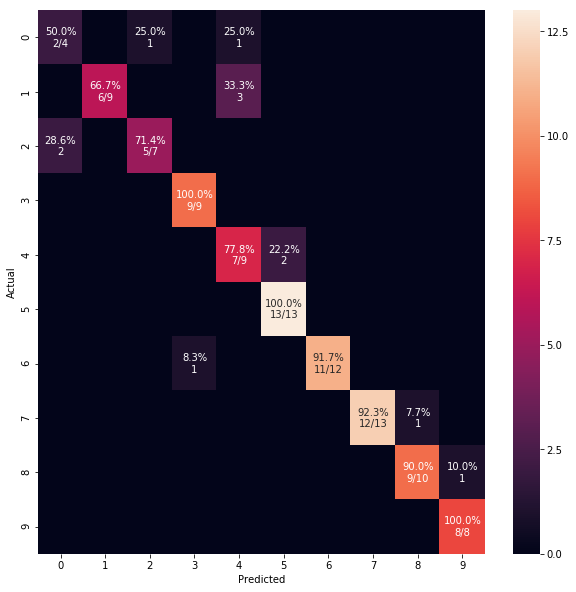

In [72]:
cm_analysis(y_test_onehot.argmax(axis=1), y_pred.argmax(axis=1), 'cm_mlp.eps', np.unique(y_test_onehot.argmax(axis=1)), figsize=(10,10))

In [0]:
'CT=9, AT=3, BC=4, ABT=2, AB=0, BCT=5, BT=6, CA=7, ABC=1, CAT=8'

'CT=9, AT=3, BC=4, ABT=2, AB=0, BCT=5, BT=6, CA=7, ABC=1, CAT=8'